In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [2]:
class PlantDiseaseDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_map = {'Healthy': 0, 'Powdery': 1, 'Rust': 2, 'Bacterial_Spot': 3, 'Black_Measles': 4, 'Black_Rot': 5, 'Gray_Leaf_Spot': 6, 'Scab': 7}
        
        split_path = os.path.join(root_dir, split)
        
        for class_name in self.class_map.keys():
            class_path = os.path.join(split_path, class_name)
            if os.path.exists(class_path):
                self._add_images(class_path, self.class_map[class_name])
            else:
                print(f"Warning: Class directory not found: {class_path}")
    
    def _add_images(self, folder_path, label):
        if not os.path.exists(folder_path):
            print(f"Folder path does not exist: {folder_path}")
            return
            
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            if self._is_valid_image(img_path):
                self.images.append(img_path)
                self.labels.append(label)
    
    def _is_valid_image(self, img_path):
        try:
            with Image.open(img_path) as img:
                img.verify()
            return True
        except (IOError, SyntaxError) as e:
            print(f"Skipping corrupted image {img_path}: {e}")
            return False
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except (IOError, OSError) as e:
            print(f"Error loading image {img_path}: {e}")
            placeholder = Image.new('RGB', (224, 224), color='gray')
            if self.transform:
                placeholder = self.transform(placeholder)
            return placeholder, label

In [3]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
def setup_data_loaders(data_root, batch_size=32):
    train_dataset = PlantDiseaseDataset(
        root_dir=data_root,
        split='Train',
        transform=transform_train
    )
    
    val_dataset = PlantDiseaseDataset(
        root_dir=data_root,
        split='Validation',
        transform=transform_val
    )
    
    print(f"Found {len(train_dataset)} training images and {len(val_dataset)} validation images")

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4
    )
    
    return train_loader, val_loader

In [6]:
model = torchvision.models.mobilenet_v3_small(pretrained=True)
model.classifier[3] = torch.nn.Linear(model.classifier[3].in_features, 8)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 126MB/s]


In [7]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()
        
        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = val_correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        scheduler.step(val_loss)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
    return model, train_losses, train_accuracies, val_losses, val_accuracies


def evaluate_model(model, data_loader, device, split="validation"):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"\n{split} Results:")
    print(f"F1 Score: {f1:.6f}")
    
    target_names = ['Healthy', 'Powdery', 'Rust', 'Bacterial_Spot', 'Black_Measles', 
                    'Black_Rot', 'Gray_Leaf_Spot', 'Scab']
    
    print(f"\n{split} Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names))
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.title(f'Confusion Matrix - {split}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return {
        'f1_score': f1,
        'predictions': all_preds,
        'true_labels': all_labels
    }

def plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

In [9]:
data_root = '/kaggle/input/plant-diseases-dataset/PlantDiseasesDataset'
train_loader, val_loader = setup_data_loaders(data_root, batch_size=16)

Found 1940 training images and 160 validation images


In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler
)

Epoch [1/20], Train Loss: 0.6337, Train Accuracy: 0.7825, Val Loss: 2.0225, Val Accuracy: 0.4437
Epoch [2/20], Train Loss: 0.1897, Train Accuracy: 0.9381, Val Loss: 0.8126, Val Accuracy: 0.7500
Epoch [3/20], Train Loss: 0.1184, Train Accuracy: 0.9603, Val Loss: 0.5347, Val Accuracy: 0.8250
Epoch [4/20], Train Loss: 0.0643, Train Accuracy: 0.9784, Val Loss: 0.7521, Val Accuracy: 0.7500
Epoch [5/20], Train Loss: 0.0565, Train Accuracy: 0.9814, Val Loss: 0.2484, Val Accuracy: 0.9000
Epoch [6/20], Train Loss: 0.0622, Train Accuracy: 0.9768, Val Loss: 0.0507, Val Accuracy: 0.9812
Epoch [7/20], Train Loss: 0.0548, Train Accuracy: 0.9804, Val Loss: 1.6827, Val Accuracy: 0.6000
Epoch [8/20], Train Loss: 0.0517, Train Accuracy: 0.9825, Val Loss: 0.0960, Val Accuracy: 0.9688
Epoch [9/20], Train Loss: 0.0584, Train Accuracy: 0.9809, Val Loss: 0.1779, Val Accuracy: 0.9500
Epoch [10/20], Train Loss: 0.0265, Train Accuracy: 0.9918, Val Loss: 0.0735, Val Accuracy: 0.9688
Epoch [11/20], Train Loss: 0.

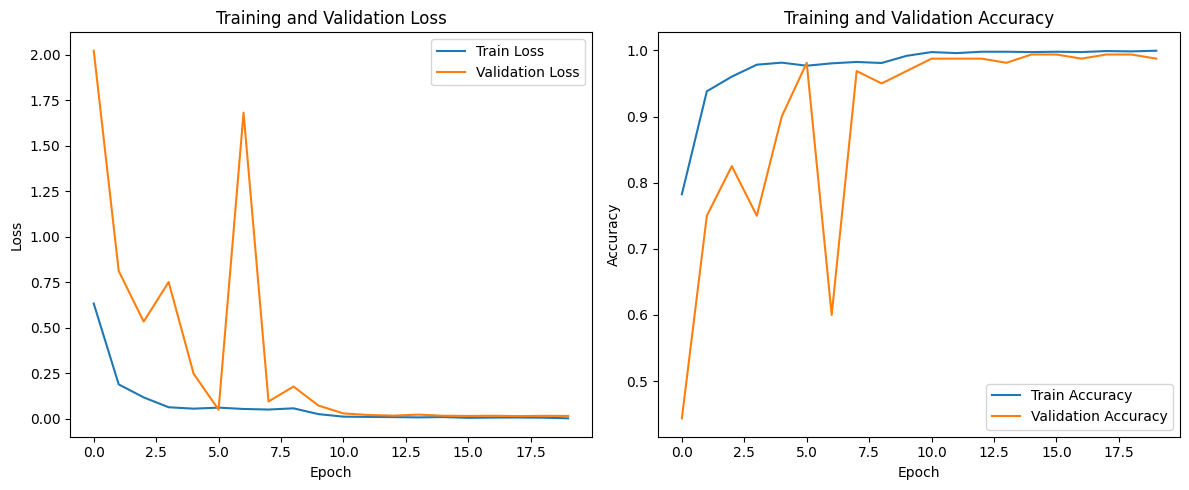

In [12]:
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies)


validation Results:
F1 Score: 0.987496

validation Classification Report:
                precision    recall  f1-score   support

       Healthy       0.95      1.00      0.98        20
       Powdery       1.00      1.00      1.00        20
          Rust       1.00      1.00      1.00        20
Bacterial_Spot       1.00      1.00      1.00        20
 Black_Measles       1.00      0.95      0.97        20
     Black_Rot       0.95      0.95      0.95        20
Gray_Leaf_Spot       1.00      1.00      1.00        20
          Scab       1.00      1.00      1.00        20

      accuracy                           0.99       160
     macro avg       0.99      0.99      0.99       160
  weighted avg       0.99      0.99      0.99       160



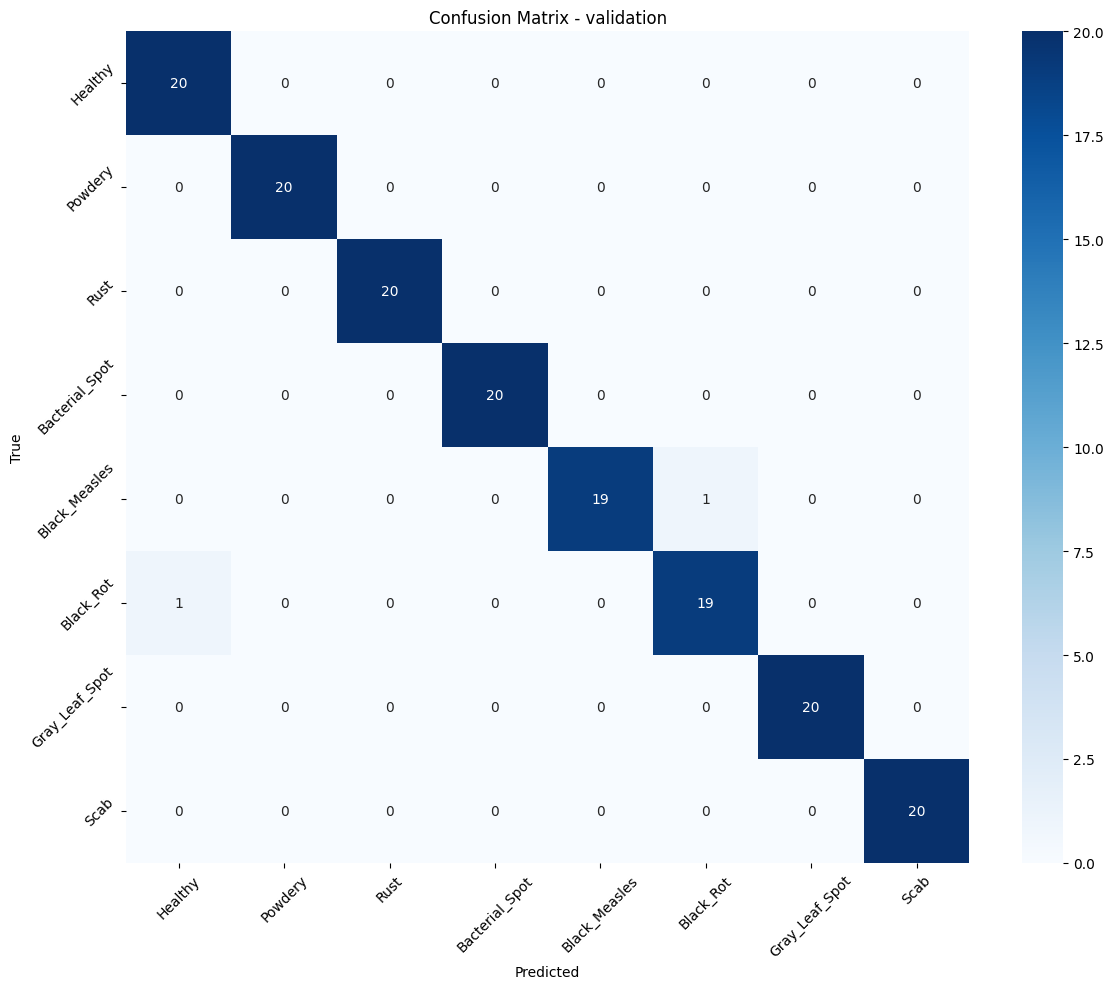

{'f1_score': 0.987496091307067,
 'predictions': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  5,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  5,
  5,
  5,
  0,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7],
 'true_labels': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  

In [13]:
evaluate_model(trained_model, val_loader, device)

In [14]:
torch.save({
        'model_state_dict': model.state_dict(),
        'model_architecture': 'mobilenet_v3_small',
        'num_classes': 8,
    }, 'plant_diseases_model.pth')